# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* DPをパラメトリックに解く

In [1]:
using Dierckx
using Optim
using Plots
#pyplot()

In [2]:
# グリッドを生成するためのモジュールを読み込む
include("GenerateGrid.jl")

Main.GenerateGrid

### カリブレーション
* パラメータをひとつの変数にまとめる：structを使う

In [3]:
struct Params
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    α::Float64 #資本分配率
    δ::Float64 #固定資本減耗

    # グリッド
    nk::Int64 #資本グリッドの数
    kmax::Float64 #資本グリッドの最大値
    kmin::Float64 #資本グリッドの最小値
    kgrid::Vector{Float64} #資本グリッド

    # 繰り返し計算
    maxit::Int64 # 繰り返し計算の最大値
    tol::Float64 # 計算誤差の許容値(tolerance of error)
end

In [4]:
function calibration()
    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 101
    kmax = 0.5 # 固定資本減耗が0.08の場合、ここを10.0にする
    kmin = 0.05

    # 自作のコードで等分のグリッドを計算
    kgrid = GenerateGrid.grid_uni(kmin, kmax, nk)
    # これまで通り⬇でもOK
    #kgrid = collect(LinRange(kmin, kmax, nk))

    maxit = 1000
    tol = 1e-5 # 2.収束の基準を設定

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, maxit, tol)
end

calibration (generic function with 1 method)

In [5]:
params = calibration();

---

## 経済学でよく使う関数

In [6]:
include("MyEconFcn.jl")

Main.MyEconFcn

---

## VFIのための準備：当て推量
* 価値関数の初期値はすべての資源を使い切った場合の効用：有限期間モデルの最終期をイメージ
    * この形である必要はまったくない

In [7]:
# 価値関数と政策関数の初期値
pfcn0 = zeros(params.nk) # すべての資源を使い切る
vfcn0 = MyEconFcn.crra.(params.kgrid.^params.α + (1-params.δ)*params.kgrid, params.γ) # すべてを消費する際の効用

pfcn1 = zeros(params.nk)
vfcn1 = zeros(params.nk)

# 繰り返し誤差を保存する変数を設定
# 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
dif = zeros(2, params.maxit);

In [8]:
# 利用可能な資産をあらかじめ計算しておく
wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid;

### Optimを使うための関数(ベルマン方程式)を設定

In [9]:
"""
k'を1つ与えた際にベルマン方程式の値を返す

### Inputs
`params::Params`: パラメータなどを含むオブジェクト
`wealth::Float64`: 今期利用可能な資産
`kprime::Float64`: 次期の資本量
`vnext::Spline1D`: 次期の価値関数をスプライン近似した際の係数

### Outputs 
`value::Float64`:　負値にしたベルマン方程式
"""
function BellmanEq(params::Params, wealth::Float64, kprime::Float64, vnext::Spline1D)
    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    value = -1*value
    return value 
end

BellmanEq

In [10]:
# 価値関数を繰り返し計算
for it = 1:params.maxit

    # 次期の価値関数を補間
    #vnext = Spline1D(params.kgrid, vfcn0, k=1, bc="extrapolate") #線形補間
    vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate") #スプライン補間

    for i = 1:params.nk
        BellmanEq!(kprime) = BellmanEq(params, wealth[i], kprime, vnext)
        res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # 最適化
        pfcn1[i] = res.minimizer
        vfcn1[i] = -res.minimum # 最小値を探していたので符号を反転させる
    end

    dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # 価値関数の繰り返し計算誤差
    dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

    # 収束途中の繰り返し計算誤差を保存
    dif[1, it] = dif1
    dif[2, it] = dif2

    vfcn0 = deepcopy(vfcn1)
    pfcn0 = deepcopy(pfcn1)

    # println("iteration counter: $it")
    # println("error (value): $dif1")
    # println("error (policy): $dif2")
    # println()

    if dif1 < params.tol
        break
    end

    if it == params.maxit
        println("The model does not converge...")
    end
end

---

## 計算速度を測るためにNumerical DPを関数化

In [11]:
"""
状態変数のみ離散化して操作変数は連続的に値を取る場合の動的計画法(parametric DP)の解法.
アルゴリズムの詳細は、Johnson et al. (1993)を参照

### Inputs
`params::Params`: パラメータ等を含む構造体

### Outputs
`vfcn0::Vector{Float64}`: 計算によって得られた価値関数
`pfcn1::Vector{Float64}`: 計算によって得られた政策関数
"""
function pdp(params::Params)

    # 価値関数と政策関数の初期化
    pfcn0 = zeros(params.nk)
    vfcn0 = MyEconFcn.crra.(params.kgrid.^params.α + (1-params.δ)*params.kgrid, params.γ)

    pfcn1 = zeros(params.nk)
    vfcn1 = zeros(params.nk)

    # 利用可能な資産をあらかじめ計算しておく
    wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid

    # 繰り返し誤差を保存する変数を設定
    # 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
    dif = zeros(2, params.maxit)

    # 価値関数を繰り返し計算
    for it = 1:params.maxit

        #次期の価値関数を補間
        #vnext = Spline1D(params.kgrid, vfcn0, k=1, bc="extrapolate") #線形補間
        vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate") #スプライン補間

        for i = 1:params.nk
            BellmanEq!(kprime) = BellmanEq(params, wealth[i], kprime, vnext)
            res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # 最適化
            pfcn1[i] = res.minimizer
            vfcn1[i] = -res.minimum # 最小値を探していたので符号を反転させる
        end

        dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # 価値関数の繰り返し計算誤差
        dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

        # 収束途中の繰り返し計算誤差を保存
        dif[1, it] = dif1
        dif[2, it] = dif2

        vfcn0 = deepcopy(vfcn1)
        pfcn0 = deepcopy(pfcn1)

        println("iteration counter: $it")
        println("error (value): $dif1")
        println("error (policy): $dif2")
        println()

        if dif1 < params.tol
            break
        end

        if it == params.maxit
            println("The model does not converge...")
        end
    end

    return vfcn0, pfcn0, dif
end

pdp

In [12]:
@time vfcn0, pfcn0, dif = pdp(params);

iteration counter: 1
error (value): 3.331788951144588
error (policy): Inf

iteration counter: 2
error (value): 0.830022066667708
error (policy): 0.25074758895473176

iteration counter: 3
error (value): 0.45111194163869056
error (policy): 0.06709209235055862

iteration counter: 4
error (value): 0.30229753296983825
error (policy): 0.02297084042565418

iteration counter: 5
error (value): 0.22394806944366524
error (policy): 0.00846324942523602

iteration counter: 6
error (value): 0.17599658688416295
error (policy): 0.0031994944207156414

iteration counter: 7
error (value): 0.14378283845663947
error (policy): 0.0012213606883703125

iteration counter: 8
error (value): 0.12071729128057757
error (policy): 0.00046802997724981526

iteration counter: 9
error (value): 0.10341856506674667
error (policy): 0.00017956469275261095

iteration counter: 10
error (value): 0.08998103662268665
error (policy): 6.90206018233483e-5

iteration counter: 11
error (value): 0.07925230416951794
error (policy): 2.6565

---

In [13]:
# 最終的な政策関数が得られてから消費関数を計算
wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid
cfcn = wealth - pfcn0;

In [14]:
# 政策関数を使って収束した価値関数を計算
util = zeros(params.nk)
valfn = zeros(params.nk)

for i = 1:params.nk
    cons = params.kgrid[i]^params.α + (1-params.δ)*params.kgrid[i] - pfcn0[i]
    util[i] = MyEconFcn.crra(cons, params.γ)
    valfn[i] = util[i] / (1-params.β)
end

In [15]:
# 解析解
AA = (1-params.β)^(-1) * (log(1-params.α*params.β) + ((params.α*params.β)/(1-params.α*params.β))*log(params.α*params.β))
BB = params.α / (1 - params.α*params.β)
v_true = AA .+ BB*log.(params.kgrid)
p_true = params.α*params.β*(params.kgrid.^params.α);

---

# プロット

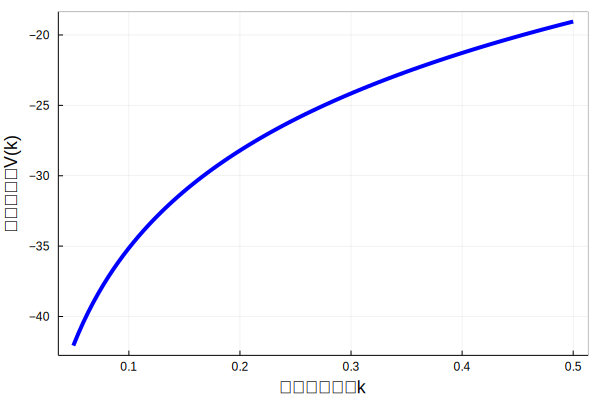

In [16]:
plt = plot(params.kgrid, valfn,
    color = :blue,
    legend = :none,
    xlabel = ("現在の資本：k"),
    ylabel = ("価値関数：V(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)

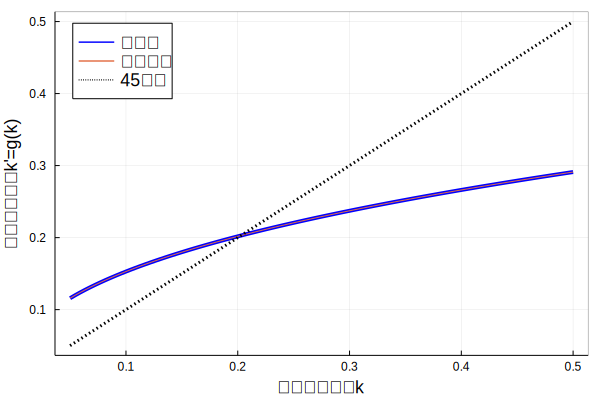

In [17]:
plt = plot(params.kgrid, pfcn0,
    color = :blue,
    legend = :topleft,
    label = ("近似解"),
    xlabel = ("現在の資本：k"),
    ylabel = ("次期の資本：k'=g(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.kgrid, p_true, linewidth = 1, label="解析的解")
plot!(params.kgrid, params.kgrid, linewidth = 3, color = "black", linestyle = :dot, label="45度線")

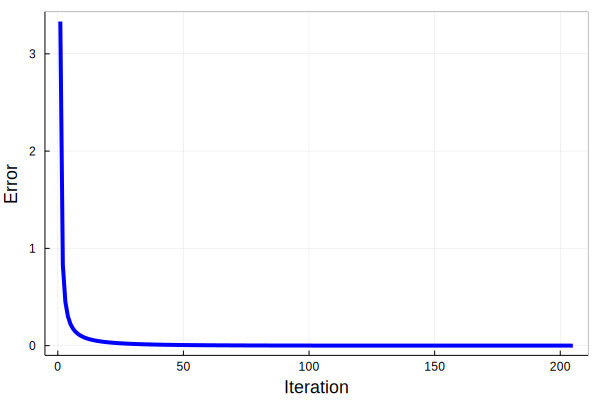

In [18]:
time = 1:205

plt = plot(time, dif[1, 1:205],
    color = :blue,
    legend = :none,
    xlabel = ("Iteration"),
    ylabel = ("Error"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)

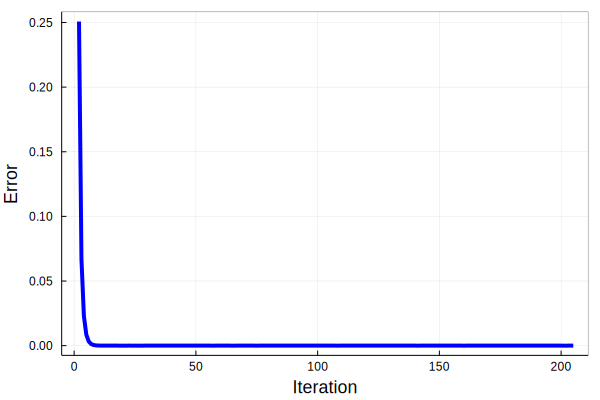

In [19]:
time = 1:205

plt = plot(time, dif[2, 1:205],
    color = :blue,
    legend = :none,
    xlabel = ("Iteration"),
    ylabel = ("Error"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)

---

## エクササイズ
* グリッドを等分から別の方法に切り替えてみよう。
    * Hint：GenerateGrid.jl内にある関数を使ってみる。
* 所得リスクを導入してみよう。